In [11]:
from datasets import load_dataset
import cv2
import albumentations
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.transforms import v2
from tqdm import tqdm

import os

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [13]:
ds = load_dataset("mrm8488/ImageNet1K-val", split="train")

ds

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image', 'label'],
    num_rows: 50000
})

In [14]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(size=(128, 128), antialias=True),
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def transform(examples):
    examples["pixel_values"] = [transforms(image) for image in examples["image"]]
    del examples["image"]
    return examples


ds.set_transform(transform)
train_test = ds.train_test_split(test_size=0.1)

trainloader = torch.utils.data.DataLoader(
    train_test["train"], batch_size=64, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    train_test["test"], batch_size=64, shuffle=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..2.3060226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3472902..1.977691].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3198047..2.605142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.1357993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21106265..2.64].
Cli

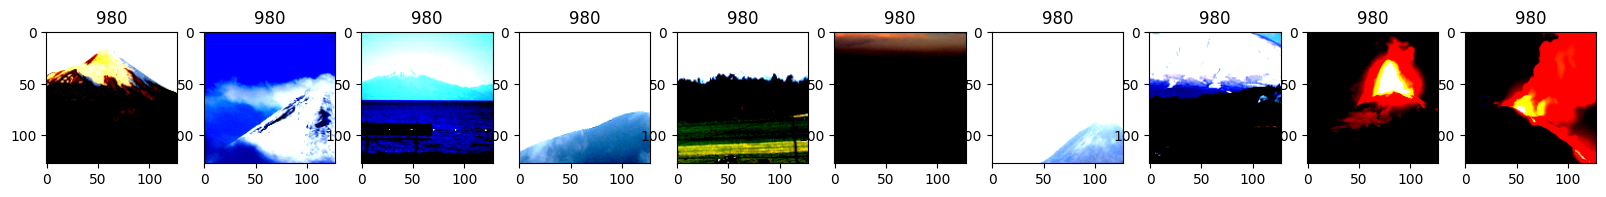

In [15]:
def show_in_row(images, labels):
    n = len(labels)
    plt.figure(figsize=(20, 6))
    for idx, item in enumerate(zip(images, labels)):
        plt.subplot(1, n, idx + 1)
        plt.imshow(item[0].permute(1, 2, 0).numpy())
        plt.title(item[1])
    plt.show()


show_in_row(ds[49000:49010]["pixel_values"], ds[49000:49010]["label"])

In [16]:
class CNN(nn.Module):
    def __init__(self, out_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)  # 124x124x16
        self.pool = nn.MaxPool2d(2, 2)  # 62x62x16
        self.conv2 = nn.Conv2d(16, 32, 5)  # 58x58x32
        self.fc1 = nn.Linear(26912, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, out_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
cnn = CNN(1000)
cnn.to(device)

optimizer = optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [18]:
def calc_corrects(model, batch):
    labels, inputs = batch.values()
    labels = labels.to(device)
    inputs = inputs.to(device)
    logits = model(inputs)

    preds = F.softmax(logits, dim=1).argmax(dim=1)
    correct = (preds == labels).sum().item()

    return correct


def save_checkpoint(accuracy, model, optimizer, loss, filename="checkpoint.pth.tar"):
    if os.path.exists(filename):
        return
    state = {
        "accuracy": accuracy,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }
    torch.save(state, filename)
    print(f"Checkpoint saved to {filename}")

In [19]:
batch_size = 64

In [ ]:
cnn.train()
print("Training..")
for epoch in range(400):
    running_loss = 0.0
    running_corrects = 0.0
    for i, data in enumerate(tqdm(trainloader)):
        labels, inputs = data.values()
        labels = labels.to(device)
        inputs = inputs.to(device)

        with torch.autocast(device_type=device, dtype=torch.float32):
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        running_corrects += calc_corrects(cnn, data)
        if i % 150 == 149:
            print(f"Loss: {running_loss / (i + 1):.4f}")
            print(f"Accuracy: {running_corrects / (i + 1):.3f}")

            if running_corrects / (i + 1) > 0.80:
                save_checkpoint(
                    running_corrects / (i + 1),
                    cnn,
                    optimizer,
                    loss,
                    "accuracy_80.pth.tar",
                )

            elif running_corrects / (i + 1) > 0.70:
                save_checkpoint(
                    running_corrects / (i + 1),
                    cnn,
                    optimizer,
                    loss,
                    "accuracy_70.pth.tar",
                )

            elif running_corrects / (i + 1) > 0.60:
                save_checkpoint(
                    running_corrects / (i + 1),
                    cnn,
                    optimizer,
                    loss,
                    "accuracy_60.pth.tar",
                )

            elif running_corrects / (i + 1) > 0.50:
                save_checkpoint(
                    running_corrects / (i + 1),
                    cnn,
                    optimizer,
                    loss,
                    "accuracy_50.pth.tar",
                )

            elif running_corrects / (i + 1) > 0.40:
                save_checkpoint(
                    running_corrects / (i + 1),
                    cnn,
                    optimizer,
                    loss,
                    "accuracy_40.pth.tar",
                )

            elif running_corrects / (i + 1) > 0.25:
                save_checkpoint(
                    running_corrects / (i + 1),
                    cnn,
                    optimizer,
                    loss,
                    "accuracy_25.pth.tar",
                )

            elif running_corrects / (i + 1) > 0.05:
                save_checkpoint(
                    running_corrects / (i + 1),
                    cnn,
                    optimizer,
                    loss,
                    "accuracy_05.pth.tar",
                )

save_checkpoint(
    running_corrects / (i * batch_size),
    cnn,
    optimizer,
    loss,
    "accuracy_final.pth.tar",
)

cnn.eval()
print("Testing..")
running_loss = 0.0
running_corrects = 0.0

for i, data in enumerate(tqdm(testloader)):
    labels, inputs = data.values()
    labels = labels.to(device)
    inputs = inputs.to(device)

    outputs = cnn(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    running_corrects += calc_corrects(cnn, data)

print(f"Loss: {running_loss / (i + 1):.4f}")
print(f"Accuracy: {running_corrects / (i + 1):.3f}")

Training..


 21%|██▏       | 151/704 [00:21<01:14,  7.41it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:43<00:58,  6.88it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:05<00:37,  6.71it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:26<00:15,  6.60it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:21<01:20,  6.88it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:43<00:54,  7.44it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:04<00:36,  6.99it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:25<00:15,  6.72it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:22<01:16,  7.22it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:44<00:59,  6.76it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:07<00:39,  6.42it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:30<00:15,  6.82it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:24,  6.51it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:10,  5.74it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 450/704 [01:10<00:37,  6.73it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.74it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:26,  6.37it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:02,  6.48it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:37,  6.74it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.61it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:25,  6.46it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:00,  6.68it/s]

Loss: 0.1083
Accuracy: 0.002


 64%|██████▍   | 451/704 [01:10<00:39,  6.49it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:17,  5.79it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.63it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:02,  6.40it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:38,  6.58it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.71it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.59it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:07,  5.96it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:44,  5.69it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:17,  6.05it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:22,  6.74it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:04,  6.29it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:39,  6.42it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:14,  7.14it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:32,  5.97it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:02,  6.49it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:39,  6.45it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:16,  6.37it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:26,  6.37it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<00:58,  6.86it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:37,  6.78it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.82it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.60it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:02,  6.47it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:38,  6.65it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.47it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:24,  6.57it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:00,  6.64it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:40,  6.24it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.57it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.66it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:04,  6.27it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:36,  7.00it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:17,  5.98it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:27,  6.30it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:02,  6.42it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:36,  6.90it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:32<00:15,  6.80it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:32,  5.98it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<00:56,  7.08it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:39,  6.47it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 600/704 [01:33<00:15,  6.70it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:22,  6.66it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:03,  6.32it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:37,  6.79it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:31<00:14,  7.31it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:21<01:14,  7.45it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:43<00:53,  7.51it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:04<00:34,  7.27it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:26<00:14,  6.95it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:21<01:17,  7.10it/s]

Loss: 0.1086
Accuracy: 0.002


 43%|████▎     | 301/704 [00:43<00:56,  7.15it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 450/704 [01:04<00:37,  6.75it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:26<00:14,  6.96it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.63it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<00:58,  6.87it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:39,  6.36it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:32<00:15,  6.46it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.65it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:07,  5.98it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:40,  6.20it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.53it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:22,  6.70it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:05,  6.15it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:39,  6.37it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 600/704 [01:33<00:15,  6.73it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:34,  5.87it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:12,  5.53it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:39,  6.45it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.80it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:29,  6.21it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:02,  6.41it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 450/704 [01:09<00:36,  7.05it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.69it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:27,  6.30it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:00,  6.66it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:37,  6.68it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.69it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:35,  5.76it/s]

Loss: 0.1086
Accuracy: 0.002


 43%|████▎     | 301/704 [00:47<01:00,  6.62it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:37,  6.68it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.68it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.60it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:06,  6.04it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:36,  6.97it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:14,  6.89it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.65it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:03,  6.38it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:38,  6.61it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.44it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:22,  6.70it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:03,  6.37it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:43,  5.84it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:16,  6.08it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:30,  6.09it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:02,  6.44it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:35,  7.11it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.49it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.66it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:03,  6.30it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 450/704 [01:09<00:40,  6.29it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:18,  5.47it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:24,  6.55it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:01,  6.50it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:38,  6.58it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:17,  5.97it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.59it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:05,  6.18it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 450/704 [01:09<00:39,  6.49it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.63it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:23,  6.64it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:08,  5.89it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:39,  6.39it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:34<00:16,  6.37it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:27,  6.35it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:03,  6.39it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:38,  6.53it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:32<00:15,  6.81it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:22,  6.73it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:01,  6.60it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:42,  5.97it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.71it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:22,  6.72it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:05,  6.15it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:38,  6.56it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.66it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:32,  6.01it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:07,  6.00it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:37,  6.78it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.56it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:26,  6.42it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:01,  6.53it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:37,  6.68it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.54it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:25,  6.49it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:06,  6.05it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:39,  6.48it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:17,  6.02it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:26,  6.40it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:02,  6.48it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:09<00:37,  6.70it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:33<00:15,  6.81it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:25,  6.46it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:46<01:02,  6.43it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:10<00:40,  6.27it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:34<00:16,  6.38it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:23,  6.59it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:03,  6.34it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:44,  5.67it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.13it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:24,  6.55it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:06,  6.10it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:39,  6.39it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:15,  6.49it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:34,  5.84it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:04,  6.23it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:43,  5.87it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.39it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:34,  5.86it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 300/704 [00:48<01:07,  5.95it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:41,  6.05it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:17,  5.86it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:26,  6.37it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:02,  6.43it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:40,  6.25it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.07it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 150/704 [00:24<01:33,  5.94it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:02,  6.50it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:37,  6.76it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.27it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:23<01:25,  6.46it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 300/704 [00:48<01:09,  5.80it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:42,  6.01it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 600/704 [01:36<00:16,  6.37it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:35,  5.81it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:04,  6.22it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:42,  5.97it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:17,  5.78it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:38,  5.63it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:07,  6.00it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:38,  6.64it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:37<00:16,  6.16it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:38,  5.63it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 300/704 [00:48<01:11,  5.64it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:41,  6.10it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.06it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:28,  6.22it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 300/704 [00:48<01:02,  6.48it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:39,  6.33it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:17,  5.82it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:23,  6.60it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:07,  5.95it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:42,  6.01it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:15,  6.48it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:25,  6.43it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:00,  6.64it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:38,  6.52it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:15,  6.44it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:23,  6.59it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:02,  6.42it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:41,  6.04it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.29it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:24,  6.52it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:05,  6.11it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:41,  6.04it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 600/704 [01:36<00:16,  6.32it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:28,  6.22it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:01,  6.58it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:39,  6.33it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.37it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:27,  6.33it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:03,  6.38it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:41,  6.09it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:15,  6.47it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:21,  6.81it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:01,  6.59it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:43,  5.86it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:15,  6.49it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 150/704 [00:23<01:33,  5.95it/s]

Loss: 0.1086
Accuracy: 0.002


 43%|████▎     | 301/704 [00:48<01:02,  6.47it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:40,  6.31it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.08it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:24,  6.54it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:47<01:03,  6.36it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:40,  6.27it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.21it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:29,  6.20it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:05,  6.17it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:39,  6.41it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:17,  5.95it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:27,  6.35it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:07,  5.95it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:42,  5.91it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:18,  5.71it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 150/704 [00:24<01:25,  6.51it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:49<01:09,  5.84it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:13<00:37,  6.67it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:37<00:16,  6.42it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:26,  6.42it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:03,  6.30it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:13<00:39,  6.46it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:15,  6.60it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:26,  6.40it/s]

Loss: 0.1086
Accuracy: 0.002


 43%|████▎     | 301/704 [00:48<01:02,  6.46it/s]

Loss: 0.1083
Accuracy: 0.002


 64%|██████▍   | 451/704 [01:13<00:41,  6.13it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:37<00:17,  6.04it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:31,  6.06it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:07,  5.99it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:38,  6.54it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:17,  6.05it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:25,  6.43it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:02,  6.44it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:44,  5.68it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:15,  6.77it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:29,  6.15it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:09,  5.78it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:39,  6.49it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:37<00:16,  6.37it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 150/704 [00:24<01:28,  6.28it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:02,  6.42it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:38,  6.52it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:15,  6.54it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:27,  6.29it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 300/704 [00:48<01:06,  6.09it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:38,  6.61it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:17,  5.96it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:27,  6.31it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:01,  6.52it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:39,  6.34it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.26it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:32,  6.00it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:49<01:07,  5.94it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:38,  6.56it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:37<00:16,  6.33it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:27,  6.32it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:00,  6.69it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:40,  6.26it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.07it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:29,  6.20it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:07,  5.94it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:38,  6.51it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:18,  5.65it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:21,  6.78it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:07,  5.98it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:40,  6.19it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:37<00:17,  5.80it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:21,  6.77it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:04,  6.30it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:12<00:40,  6.21it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.34it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:37,  5.66it/s]

Loss: 0.1087
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:03,  6.38it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:13<00:41,  6.15it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:16,  6.38it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:26,  6.42it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:05,  6.15it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 450/704 [01:12<00:41,  6.18it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:36<00:15,  6.55it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:30,  6.10it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:04,  6.27it/s]

Loss: 0.1083
Accuracy: 0.001


 64%|██████▍   | 451/704 [01:13<00:39,  6.34it/s]

Loss: 0.1082
Accuracy: 0.001


 85%|████████▌ | 601/704 [01:37<00:17,  6.01it/s]

Loss: 0.1081
Accuracy: 0.001


 21%|██▏       | 151/704 [00:24<01:23,  6.62it/s]

Loss: 0.1086
Accuracy: 0.001


 43%|████▎     | 301/704 [00:48<01:08,  5.90it/s]

Loss: 0.1083
Accuracy: 0.001


 54%|█████▍    | 382/704 [3:01:06<04:17,  1.25it/s]      